In [1]:
import json
from collections import Counter, defaultdict
import pandas as pd
from io import BytesIO
from zipfile import ZipFile
from coco_utilities import get_image_to_class_count_dataframe
from metric_utilities import compute_class_distribution, compute_deviation_metrics
from metric_utilities import compute_distribution_from_df, compute_ratio_deviation
from metric_utilities import compute_split_ratio_deviation
from optimization_routine import stratified_k_way_split_respecting_partition
from coco_utilities import sub_sample_count_dataframe, get_dataframe_count_datastructures
from coco_utilities import construct_coco_split_from_assignments
from metric_utilities import plot_metric_vs_image_size
from metric_utilities import compare_metric_overlay

# This file assumes the 'full_coco_data.json' has been loaded
with open("full_coco_data.json",'rb') as f:
    global_coco = json.load(f)
print(len(global_coco['images']))

# --------- Config ---------------
# classes to run the experiment over
n_classes = 10

# partition sizes
split_ratios = [0.8,0.2] # split weights (must sum to one)
# these indexes correspond to the array in split_ratios
assignment_index_to_name = {0:"train",1:"val"}

# object sizes to extract and partition
# currently only these small sizes work for this simple experment.
# We first sample columns but many time if we extract too many images
# we may not be able to ensure >0 classes per image with the restricted class space
image_sizes_to_sample = [200, 400, 600] 


# image_sizes_to_sample = [200, 400, 600, 1200, 5000]

# number of runs per each image 
n_runs_per_image_size = 10

# -------------------------------

df = get_image_to_class_count_dataframe(global_coco)


5000


This file runs the stratified partitioning vs random partitioning to examine deviations of the splits from the
global  class distribution. We also examine the deviation of the split ratio enforcement because class balance may not 
be satisfiable with stratification (the values of lambda_class and lambda_cardinality provide a mechanism to 
decide relative weights between these two competing objectives).

In [2]:
# Compute the metrics using the stratified k-way split method

stratified_all_metrics = defaultdict(lambda: defaultdict(list))  # {split_name: {metric_name: [values]}}

for size in image_sizes_to_sample:
    n_images = size
    # run the stratification
    for exp_index in range(n_runs_per_image_size):
        if n_images < df.shape[0]:
            df_subsample = sub_sample_count_dataframe(df,n_images,n_classes)
        else:
            df_subsample = df.copy()
        class_counts_per_image,index_to_image_id,index_to_class_name,class_names,image_ids = get_dataframe_count_datastructures(df_subsample)
        assignments = stratified_k_way_split_respecting_partition(n_images,n_classes,class_counts_per_image,split_ratios)

        coco_per_assignment = construct_coco_split_from_assignments(global_coco,
                                                            assignments,
                                                            index_to_image_id,
                                                            assignment_index_to_name)
        
        global_dist = compute_distribution_from_df(df_subsample)

        # Ratio deviation (image count level)
        ratio_devs = compute_split_ratio_deviation(coco_per_assignment, split_ratios, assignment_index_to_name, total_images=n_images)
        for split_name, dev in ratio_devs.items():
            stratified_all_metrics[(n_images, split_name)]["ratio_dev"].append(dev)

        # For each split, compute metrics and record
        for split_name, split_coco in coco_per_assignment.items():
            split_dist = compute_class_distribution(split_coco, class_names)
            metrics = compute_deviation_metrics(global_dist, split_dist)

            for metric_name, value in metrics.items():
                stratified_all_metrics[(n_images, split_name)][metric_name].append(value)



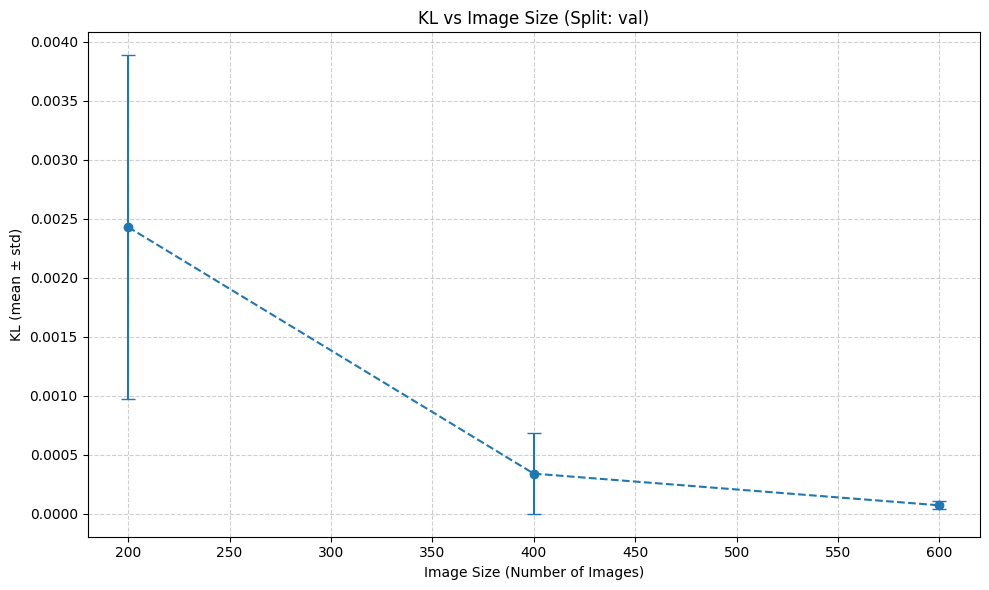

<Axes: title={'center': 'KL vs Image Size (Split: val)'}, xlabel='Image Size (Number of Images)', ylabel='KL (mean ± std)'>

In [3]:
plot_metric_vs_image_size(
    stratified_all_metrics,
    metric_name='kl',
    split_name='val',
    central_tendency='mean',
    spread='std'
)


In [4]:
from coco_utilities import sub_sample_count_dataframe
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter

# compute the metrics for a random image split
random_all_metrics = defaultdict(lambda: defaultdict(list))  # {split_name: {metric_name: [values]}}

for size in image_sizes_to_sample:
    n_images = size
    # run the stratification
    for exp_index in range(n_runs_per_image_size):

        if n_images < df.shape[0]:
            df_subsample = sub_sample_count_dataframe(df,n_images,n_classes)
        else:
            df_subsample = df.copy()
        
        global_dist = compute_distribution_from_df(df_subsample)

        # Compute number of images per split
        n_train = int(split_ratios[0] * n_images)
        df_shuffled = df_subsample.sample(frac=1.0).reset_index(drop=True)
        df_splits = {
            assignment_index_to_name[0]: df_shuffled.iloc[:n_train],
            assignment_index_to_name[1]: df_shuffled.iloc[n_train:]
        }

        for split_name, split_df in df_splits.items():
            split_dist = compute_distribution_from_df(split_df)
            deviations = compute_deviation_metrics(global_dist, split_dist)
            for k, v in deviations.items():
                random_all_metrics[(n_images, split_name)][k].append(v)

            # Ratio deviation (image-count based) , zero here always
            split_ratio_target = split_ratios[0] if split_name == assignment_index_to_name[0] else split_ratios[1]
            ratio_dev = compute_ratio_deviation(n_images, len(split_df), split_ratio_target)
            random_all_metrics[(n_images, split_name)]["ratio_dev"].append(ratio_dev)

            

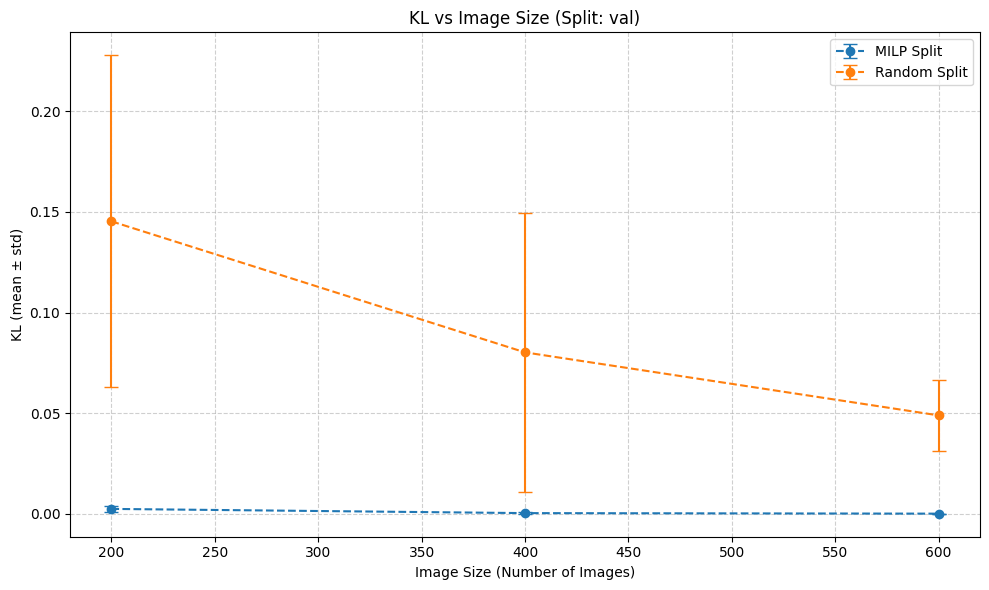

In [5]:
compare_metric_overlay(
    all_metrics_1=stratified_all_metrics,
    all_metrics_2=random_all_metrics,
    label_1="MILP Split",
    label_2="Random Split",
    split_name="val",
    metric_name="kl",
    central_tendency="mean",
    spread="std"
)
